In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

# Classification task: other models

There are several models that perform Classification, each with a different behavior.

We briefly explore some of the differences.

## Decision boundaries

Just as we saw for the Regression task:
- there are multiple models for solving a Classification task

For Binary Classification
- the models create different decision boundaries

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

In [4]:
# Create a more challenging dataset
X, y = make_classification(
    n_samples=200,  # Increased number of samples to have enough data for training and testing
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=2,
    class_sep=0.5,
    flip_y=0.1,
    random_state=42
)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
k_neighbors = 3
tree_depth = 3

rf_depth, rf_trees = 2, 5

classifiers = {
    'Logistic Regression': LogisticRegression(),
    f'K-Nearest Neighbors (k={k_neighbors})': KNeighborsClassifier(n_neighbors=k_neighbors),
    # 'SVM (Linear Kernel)': SVC(kernel='linear'),
    'SVM (RBF Kernel)': SVC(kernel='rbf', random_state=42),
    f'Decision Tree (Depth={tree_depth})': DecisionTreeClassifier(max_depth=tree_depth),
    f'Random Forest (Depth={rf_depth}, {rf_trees} Trees)':  RandomForestClassifier(max_depth=rf_depth,
                                                                                   n_estimators=rf_trees
                                                                                  )
                                              
}

In [6]:
# Fit the classifiers and compute accuracy
accuracies = {}
for name, clf in classifiers.items():
    _= clf.fit(X_train, y_train)
    accuracies[name] = clf.score(X_test, y_test)

# Plot the decision boundaries
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

fig, axes = plt.subplots(int(0.5 + len(classifiers.keys())/2), 2, figsize=(12, 12))
axes = axes.ravel()

for idx, (name, clf) in enumerate(classifiers.items()):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    _= axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(('red', 'blue')))
    _=axes[idx].scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=ListedColormap(('red', 'blue')))
    _=axes[idx].set_title(f'{name}\nAccuracy: {accuracies[name]:.2f}')
    
plt.tight_layout()

# Hide the figure (for now)
plt.close(fig)


/home/kjp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kjp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


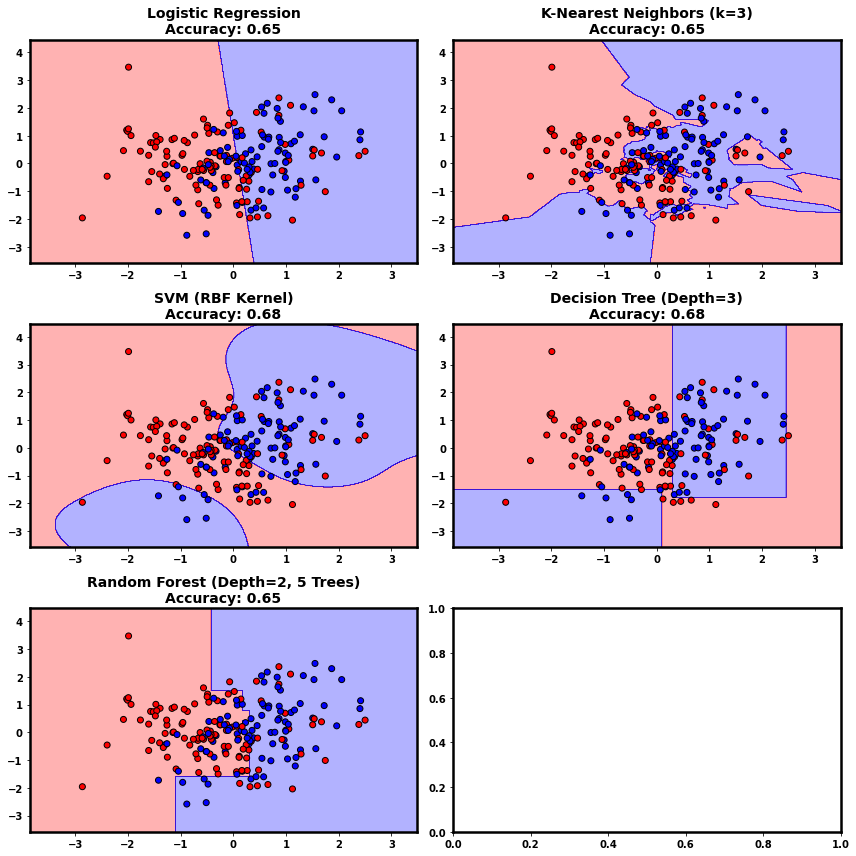

In [7]:
fig

The choice of which model to use may reflect your prior assumption of what the boundary should be
- Logistic Regression: linearly separable classes
- KNN: high $k$ may result in poor generalization
- Decision tree
    - boundaries are perpendicular to axis
    - e.g., vertical boundary is line of constant value  of feature on horizontal axis
- Random Forest
    - may result in poor generalization with too many trees in the forest

## Output: probabilities or just classes ?

The ultimate output of a classifier
- is a single class label
- prediction of the class to which the example belongs

But many Classifiers output a *probability distribution* over all the classes
$$
\prc{\y}{\x}
$$
where $\prc{\y}{\x}$
- is a vector whose length is the number of classes

There are several possibilities for converting the probability vector to a single class
- choose the class with highest probability
    - e.g., in KNN
        -  we chose the class for a test example
        - by comparing against $k$ training examples
        - and choosing the class $c$ that whose label was most frequent among the $k$ examples
        
- for Binary Classification
    - compare probability of the Positive class to a threshold
    - choose class "Positive" only if the  predicted probability of Positive exceeds the threshold
    

Some (but not all) classifiers in `sklearn`
- implement a method `predict_proba`
    - that returns the probability vector

For Classifiers that return probability vectors
- the ultimate class label predicted
- *can be adjusted by the user*

Here is some pseudo-code:

    # Train a logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Get predicted probabilities for new data
    probabilities = model.predict_proba(X_test)[:, 1]  # Probability of positive class

    # Set a custom threshold (e.g., 0.7)
    custom_threshold = 0.7

    # Make predictions based on the custom threshold
    predictions = (probabilities >= custom_threshold).astype(int)


In the [Precision/Recall tradeoff](Error_Analysis.ipynb#Precison/Recall-Tradeoff) module
- we examined the effect of changing the threshold
- on conditional Performance Metrics
    - recall, precision

There is a [good discussion](https://scikit-learn.org/stable/modules/classification_threshold.html) on adjusting the probability threshold in the `sklearn` documentation.

## Reliability diagrams

We can also compare Classifiers
- by comparing the predictions
- across a wide range of examples

For Classifiers that produce probability distributions
- how confident is the Classifier in its prediction ?
    - examine the distribution of probability mass across many examples
    
A confident Classifier's distribution is bimodal
- most of the probability mass near $0$ or $1$

Another property:

How reliable is the prediction ?
- for Binary Classification
- examine all the examples assigned predicted probability $\hat p = P$ of being Positive
- the fraction $p$ of these examples whose true labels are Positive
- should be close to $\hat p$

A plot of $p$ versus $\hat p$ is called a *Reliability diagram*

See [here](https://scikit-learn.org/stable/modules/calibration.html) for explanation
and [here](https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html) for code.

In [8]:
print("Done")

Done
